# Домашнее задание №2

Во втором ДЗ мы, используя данные, полученные в первом ДЗ, создаём и обучаем модель, используя признаки из тех. анализа, и оцениваем её эффективность:

~~1. Создать код на Python, который разделит ваши данные на тренировочный, тестовый и валидационный наборы данных.~~

~~2. Построить одну или несколько моделей на основе паттернов технического анализа, которая будет принимать торговые решения по бумагам SnP500 и/или криптовалютам.~~

~~3. Провести подбор гиперпараметров моделей с использованием обучающей и тестовой выборок.~~

~~4. Провести финальное тестирование построенных торговых стратегий на валидационном наборе данных и сравнить их между собой.~~

~~5. Сформировать дашборд, показывающий эффективность различных стратегий во времени.~~ (работал с одной стратегией из-за того, что сильно пропустил дедлайн)

*Прим.: ниже приведено ДЗ1, которое я поместил в отдельный раздел - его можно и нужно свернуть при проверке ДЗ2*

---

# ДЗ1

## 0: Импорты

In [1]:
#%pip install pandas
#%pip install requests
#%pip install bs4
#%pip install yfinance --upgrade --no-cache-dir
#%pip install plotly
#%pip install nbformat --upgrade
#%pip install ipywidgets
#%pip install matplotlib
#%pip install scikit-learn
#%pip install mpl_finance

In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import yfinance as yf
import matplotlib as mpl

In [3]:
# задаю random_state на весь проект для воспроизводимости результатов
RANDOM_STATE = 797777

In [4]:
# использую warnings, чтобы заглушить предупреждения Pandas в нескольких местах в моей работе
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

## 3: Загрузка данных

### 3.a: Загрузка данных о компаниях SNP500

In [5]:
url = 'https://en.m.wikipedia.org/wiki/List_of_S%26P_500_companies' # ссылка на страницу Википедии с тикерами всех компаний индекса SNP500

# собираю тикеры всех компаний из SNP500 в список tickers_snp
tickers_df = pd.read_html(url, attrs={'id': 'constituents'}, index_col='Symbol')[0]
tickers_snp = tickers_df.index.to_list()

*Примечание: я нашёл, как загрузить все тикеры акций SNP500, и реализовал выше; но решил в проекте использовать только 5 с наибольшей рыночной капитализцией (а значит, с самым большим весом в индексе), поскольку работать с данными придётся вручную*

In [6]:
tickers_snp_top5 = ["AAPL", "NVDA", "MSFT", "AMZN", "GOOG"]

In [7]:
# с помощью yfinance скачиваю данные о топ-5 компаниях индекса SNP500 и кладу их в датафрейм df_snp
df_snp = yf.download(tickers=tickers_snp_top5,
                     period="1mo",
                     interval="15m",
                     group_by="ticker")
df_snp.index = pd.to_datetime(df_snp.index)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


### 3.b: Загрузка данных о криптовалютах (BTC, ETH, SOL, XPR)

In [8]:
tickers_ccur = ["BTC-USD", "ETH-USD", "SOL-USD", "XPR-USD"] # список с тикерами криптовалют

In [9]:
# с помощью yfinance скачиваю данные о криптовалютах и кладу их в датафрейм df_ccur
df_ccur = yf.download(tickers=tickers_ccur,
                      period="1mo",
                      interval="15m",
                      group_by="ticker")
df_ccur.index = pd.to_datetime(df_ccur.index)

[*********************100%***********************]  4 of 4 completed


In [10]:
# создаю простые графики с ценами закрытия для Apple и BTC, чтобы удостовериться, что загрузка данных прошла успешно

fig = go.Figure(layout={"margin" : {"b" : 10, "l" : 5, "t" : 10}})
figwid = go.FigureWidget(fig)

figwid.add_trace(go.Scatter(x=df_snp.index,
                         y=df_snp[("AAPL", "Close")],
                         mode="lines",
                         name="Цена закрытия Apple",
                         showlegend=True,
                         line={"color" : "#171CC9"}))
figwid.show()

figwid.data = []
figwid.add_trace(go.Scatter(x=df_ccur.index,
                         y=df_ccur[("BTC-USD", "Close")],
                         mode="lines",
                         name="Цена закрытия BTC",
                         showlegend=True,
                         line={"color" : "#814E1D"}))
figwid.show()

## 4) Заполнение пропусков, создание загрузчика и вывод графиков

### 4.a) Заполнение пропусков

In [11]:
df_joined = pd.concat([df_snp, df_ccur], axis=1)
df_joined.isna().sum()

Ticker   Price 
MSFT     Open      2405
         High      2405
         Low       2405
         Close     2405
         Volume    2405
GOOG     Open      2405
         High      2405
         Low       2405
         Close     2405
         Volume    2405
AMZN     Open      2405
         High      2405
         Low       2405
         Close     2405
         Volume    2405
NVDA     Open      2405
         High      2405
         Low       2405
         Close     2405
         Volume    2405
AAPL     Open      2405
         High      2405
         Low       2405
         Close     2405
         Volume    2405
ETH-USD  Open         0
         High         0
         Low          0
         Close        0
         Volume       0
BTC-USD  Open         0
         High         0
         Low          0
         Close        0
         Volume       0
SOL-USD  Open         0
         High         0
         Low          0
         Close        0
         Volume       0
XPR-USD  Open         0


*Поскольку для построения практически всех индикаторов данные должны быть без пропусков, я решил первым делом заполнить пропуски*

Пропуски - это данные об акциях из SNP500 за период с 15:30 до 9:30 следующего дня (не включая выходные), поскольку в это время акции не торгуются, а криптовалюты торгуются. Поэтому заполним пропуски следующим образом:
* Close - с помощью ffill перенесём предыдущее известное значение
* Open, High, Low - приравняем к Close
* Volume - поскольку торгов не было, зададим его равным нулю

In [12]:
empty_rows = df_joined.isna().index
for col in df_snp.columns.get_level_values(0):
    df_joined[(col, "Close")].ffill(inplace=True)
    df_joined.loc[empty_rows, (col, "Open")] = df_joined.loc[empty_rows, (col, "Close")]
    df_joined.loc[empty_rows, (col, "High")] = df_joined.loc[empty_rows, (col, "Close")]
    df_joined.loc[empty_rows, (col, "Low")] = df_joined.loc[empty_rows, (col, "Close")]
    df_joined[(col, "Volume")].fillna(0, inplace=True)
df_joined.isna().sum()

Ticker   Price 
MSFT     Open      24
         High      24
         Low       24
         Close     24
         Volume     0
GOOG     Open      24
         High      24
         Low       24
         Close     24
         Volume     0
AMZN     Open      24
         High      24
         Low       24
         Close     24
         Volume     0
NVDA     Open      24
         High      24
         Low       24
         Close     24
         Volume     0
AAPL     Open      24
         High      24
         Low       24
         Close     24
         Volume     0
ETH-USD  Open       0
         High       0
         Low        0
         Close      0
         Volume     0
BTC-USD  Open       0
         High       0
         Low        0
         Close      0
         Volume     0
SOL-USD  Open       0
         High       0
         Low        0
         Close      0
         Volume     0
XPR-USD  Open       0
         High       0
         Low        0
         Close      0
         Volume 

У нас осталось ещё несколько пропусков - это данные на начало первого дня (с 00:00 до 09:15), которые не получилось заполнить с помощью ffill(), т.к. попросту нету предыдущего известного значения. Значит, эти пропуски мы заполним аналогичным образом, но с помощью bfill() вместо ffill().

In [13]:
empty_rows = df_joined.isna().index
for col in df_snp.columns.get_level_values(0):
    df_joined[(col, "Close")].bfill(inplace=True)
    df_joined.loc[empty_rows, (col, "Open")] = df_joined.loc[empty_rows, (col, "Close")]
    df_joined.loc[empty_rows, (col, "High")] = df_joined.loc[empty_rows, (col, "Close")]
    df_joined.loc[empty_rows, (col, "Low")] = df_joined.loc[empty_rows, (col, "Close")]
df_joined.isna().sum()

Ticker   Price 
MSFT     Open      0
         High      0
         Low       0
         Close     0
         Volume    0
GOOG     Open      0
         High      0
         Low       0
         Close     0
         Volume    0
AMZN     Open      0
         High      0
         Low       0
         Close     0
         Volume    0
NVDA     Open      0
         High      0
         Low       0
         Close     0
         Volume    0
AAPL     Open      0
         High      0
         Low       0
         Close     0
         Volume    0
ETH-USD  Open      0
         High      0
         Low       0
         Close     0
         Volume    0
BTC-USD  Open      0
         High      0
         Low       0
         Close     0
         Volume    0
SOL-USD  Open      0
         High      0
         Low       0
         Close     0
         Volume    0
XPR-USD  Open      0
         High      0
         Low       0
         Close     0
         Volume    0
dtype: int64

Всп пропуски успешно заполнены, переходим к созданию загрузчика и автоматического вывода графиков.

In [14]:
# по непонятной мне причине yfinance скачивает данные о криптовалютах за последний месяц, как я его и прошу, а об акциях из SNP500 - добавляет
# несколько дней перед началом указанного периода. Поэтому я выбрасываю эти значения после заполнения всех "реальных" пропусков
df_joined.dropna(inplace=True)

### 4.b): Создание загрузчика данных

Я решил создать загрузчик, который будет автоматически обновлять график каждый раз, когда пользователь его вызывает. То есть каждый вызов data_loader() будет загружать самые актуальные данные

*Примечание: в загрузчике я буду задавать некоторые переменные, которые уже были заданы выше в секциях 3.a) и 3.b); я делаю это специально, как будто пишу загрузчик "с нуля"*

In [15]:
def data_loader():

    tickers_snp_top5 = ["AAPL", "NVDA", "MSFT", "AMZN", "GOOG"]
    tickers_ccur = ["BTC-USD", "ETH-USD", "SOL-USD", "XPR-USD"]
    
    # загрузка данных

    df_snp = yf.download(tickers=tickers_snp_top5,
                     period="1mo",
                     interval="15m",
                     group_by="ticker")
    df_snp.index = pd.to_datetime(df_snp.index)

    df_ccur = yf.download(tickers=tickers_ccur,
                      period="1mo",
                      interval="15m",
                      group_by="ticker")
    df_ccur.index = pd.to_datetime(df_ccur.index)

    df_joined = pd.concat([df_snp, df_ccur], axis=1)

    # заполнение пропусков
    
    empty_rows = df_joined.isna().index
    for col in df_snp.columns.get_level_values(0):
        df_joined[(col, "Close")].ffill(inplace=True)
        df_joined.loc[empty_rows, (col, "Open")] = df_joined.loc[empty_rows, (col, "Close")]
        df_joined.loc[empty_rows, (col, "High")] = df_joined.loc[empty_rows, (col, "Close")]
        df_joined.loc[empty_rows, (col, "Low")] = df_joined.loc[empty_rows, (col, "Close")]
        df_joined.loc[empty_rows, (col, "Volume")] = 0

    empty_rows = df_joined.isna().index
    for col in df_snp.columns.get_level_values(0):
        df_joined[(col, "Close")].bfill(inplace=True)
        df_joined.loc[empty_rows, (col, "Open")] = df_joined.loc[empty_rows, (col, "Close")]
        df_joined.loc[empty_rows, (col, "High")] = df_joined.loc[empty_rows, (col, "Close")]
        df_joined.loc[empty_rows, (col, "Low")] = df_joined.loc[empty_rows, (col, "Close")]
        df_joined.loc[empty_rows, (col, "Volume")] = 0

    # по непонятной мне причине yfinance скачивает данные о криптовалютах за последний месяц, как я его и прошу, а об акциях из SNP500 - добавляет
    # несколько дней перед началом указанного периода. Поэтому я выбрасываю эти значения после заполнения всех "реальных" пропусков
    df_joined.dropna(inplace=True)
    
    # построение графиков

    fig = go.Figure(layout={"margin" : {"b" : 10, "l" : 5, "t" : 10}})
    figwid = go.FigureWidget(fig)
    for ticker in tickers_snp_top5 + tickers_ccur:
        figwid.add_trace(go.Scatter(x=df_joined.index,
                         y=df_joined[(ticker, "Close")],
                         mode="lines",
                         name=f"Цена закрытия {ticker}",
                         showlegend=True))
        figwid.add_trace(go.Scatter(x=df_joined.index,
                         y=df_joined[((ticker, "Close"))].rolling(10).mean(),
                         mode="lines",
                         name=f"10-барная MA {ticker}"))
        figwid.add_trace(go.Scatter(x=df_joined.index,
                         y=df_joined[((ticker, "Close"))].ewm(span=10).mean(),
                         mode="lines",
                         name=f"10-барная EMA {ticker}"))
        figwid.show()
        figwid.data = []

In [16]:
# при выполнении этой ячейки автоматически скачиваются самые новые данные и строятся графики

data_loader()

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  4 of 4 completed


## 5) Анализ данных

### 5.a) Пропуски и ошибки

Всё обработал выше - см. пункт 4.а

### 5.b) Работа с выбросами

Начнём с простых боксплотов:

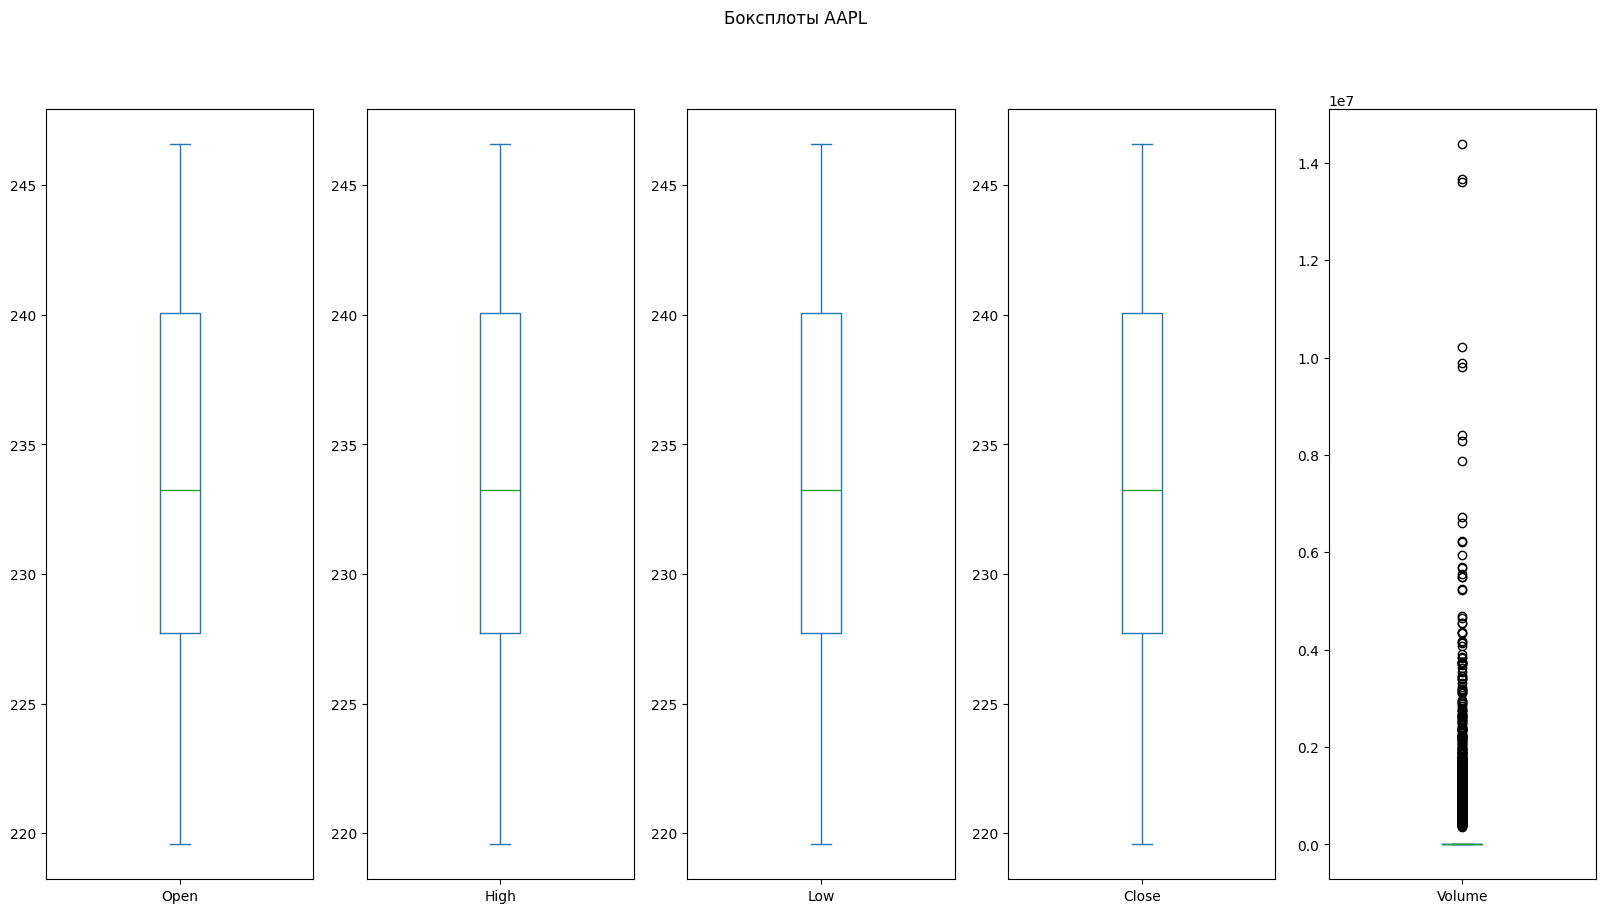

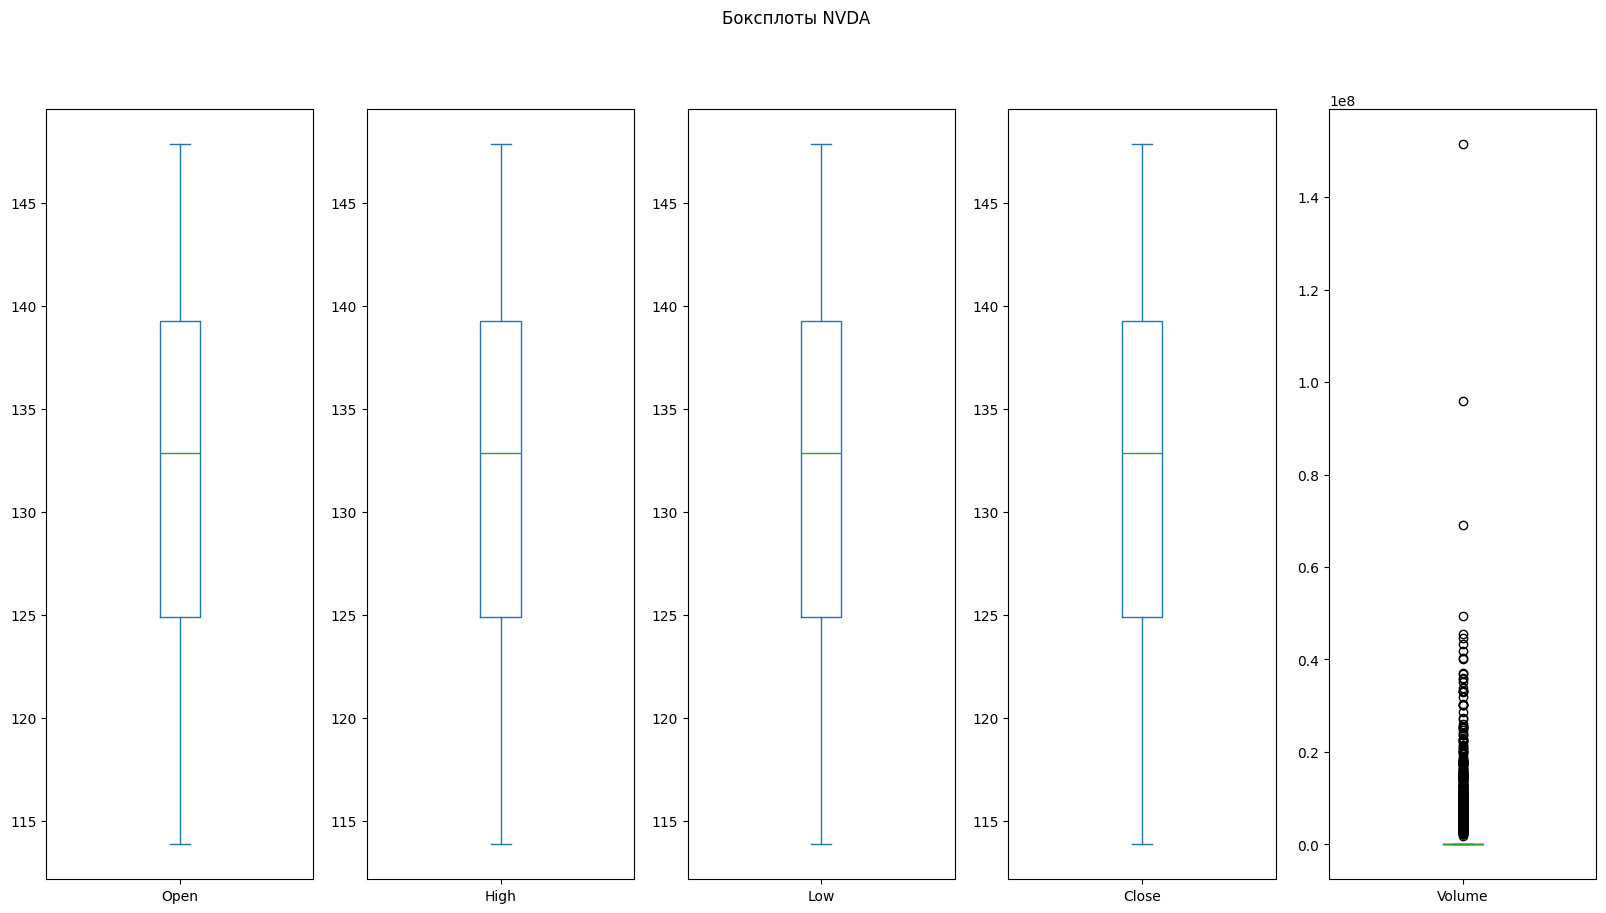

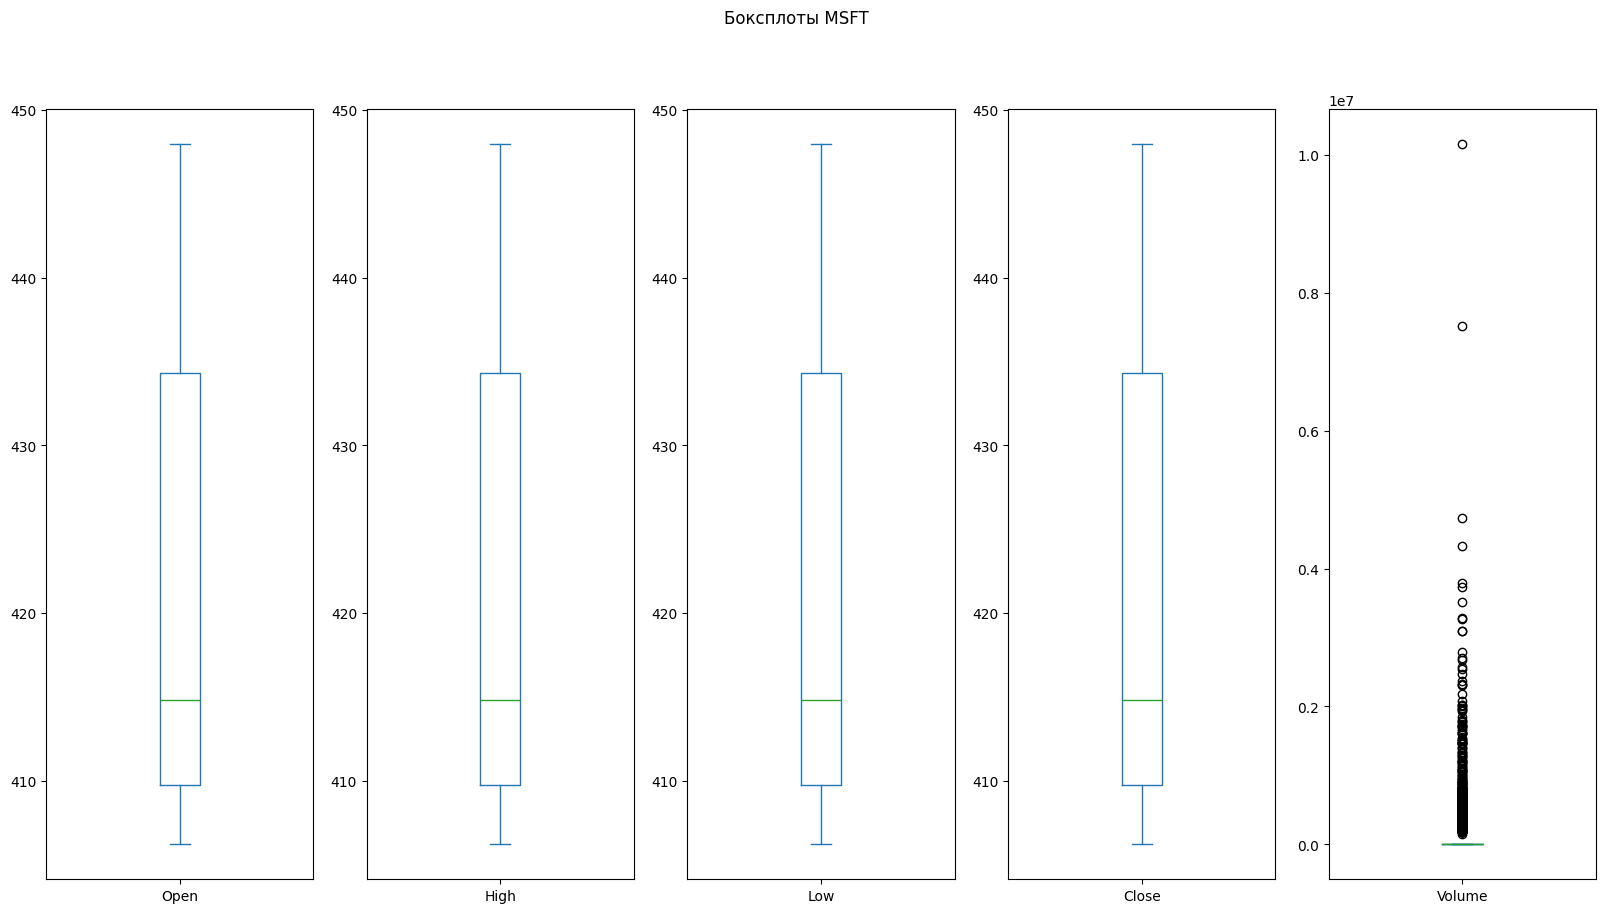

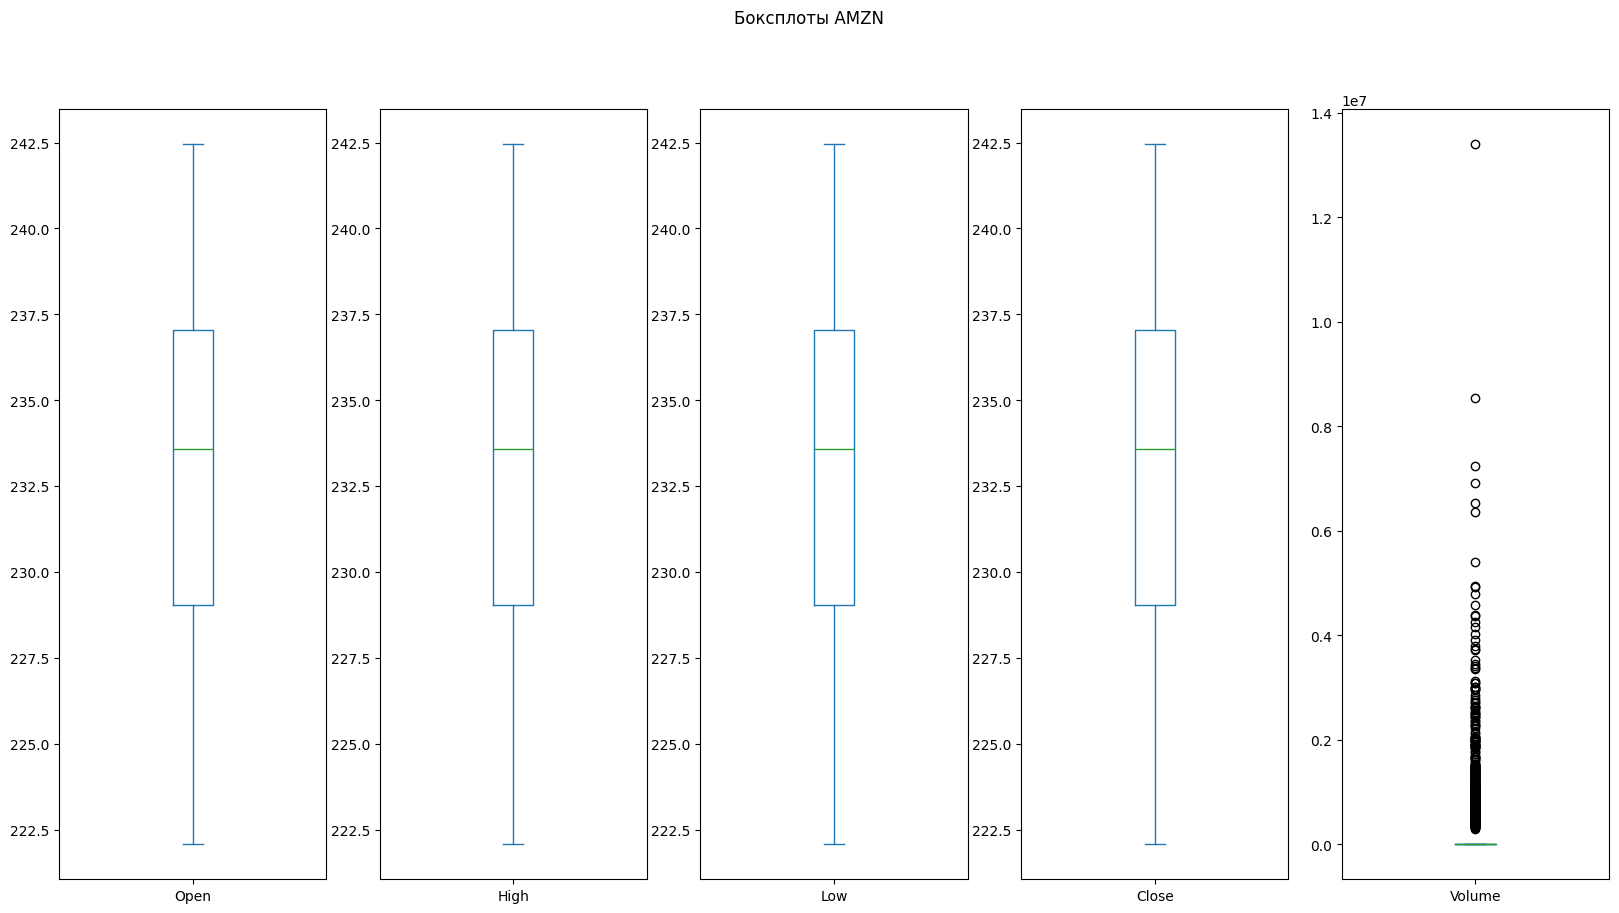

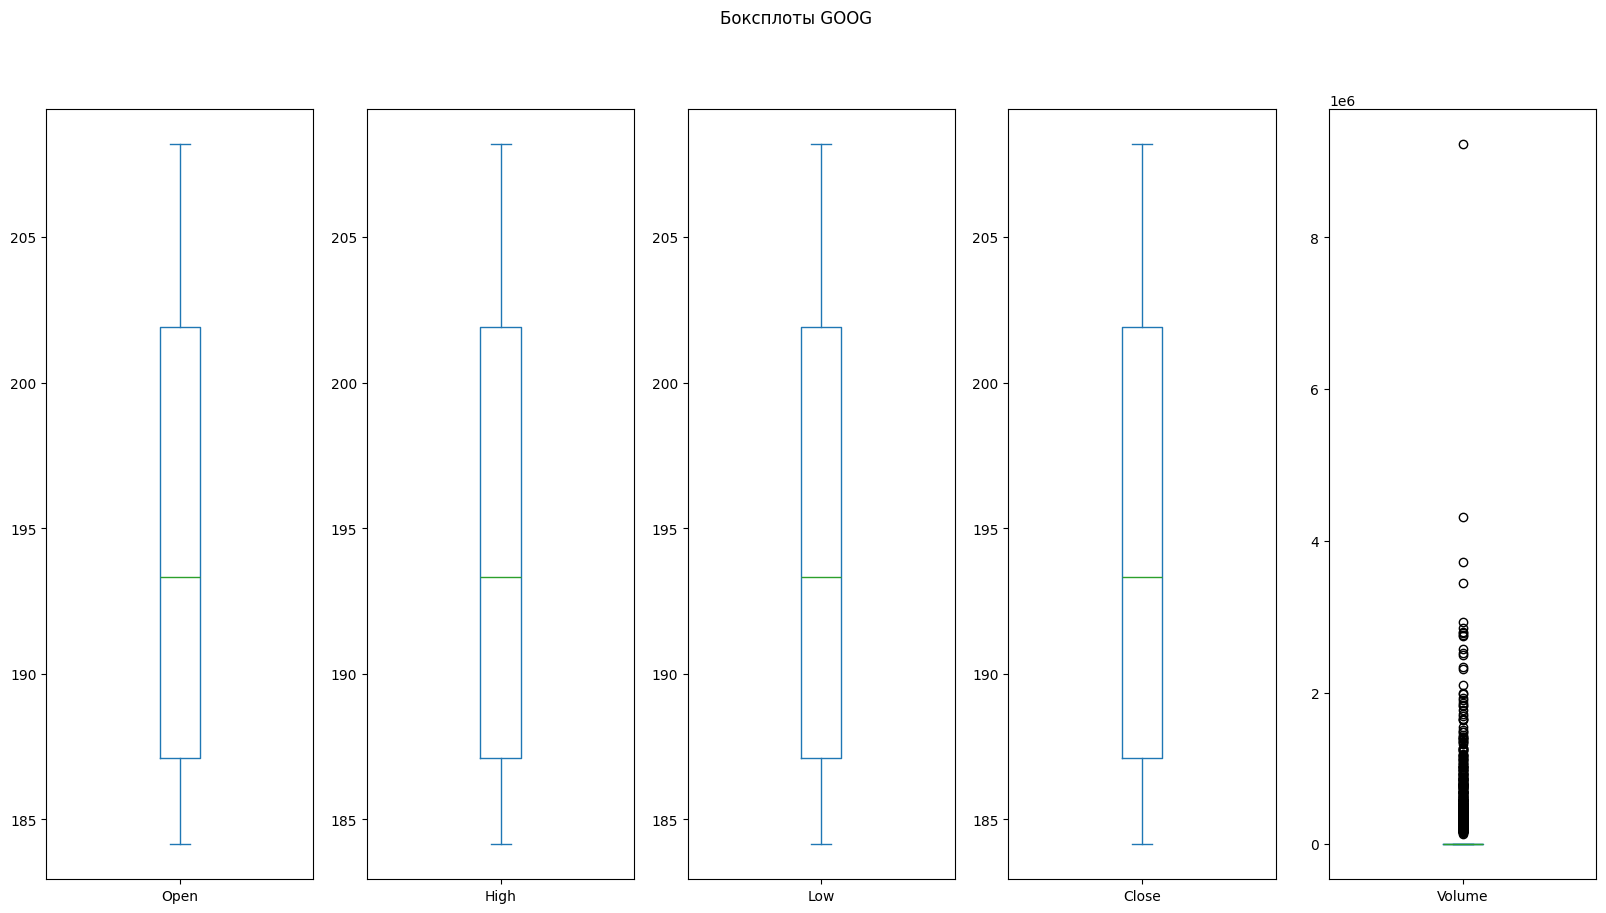

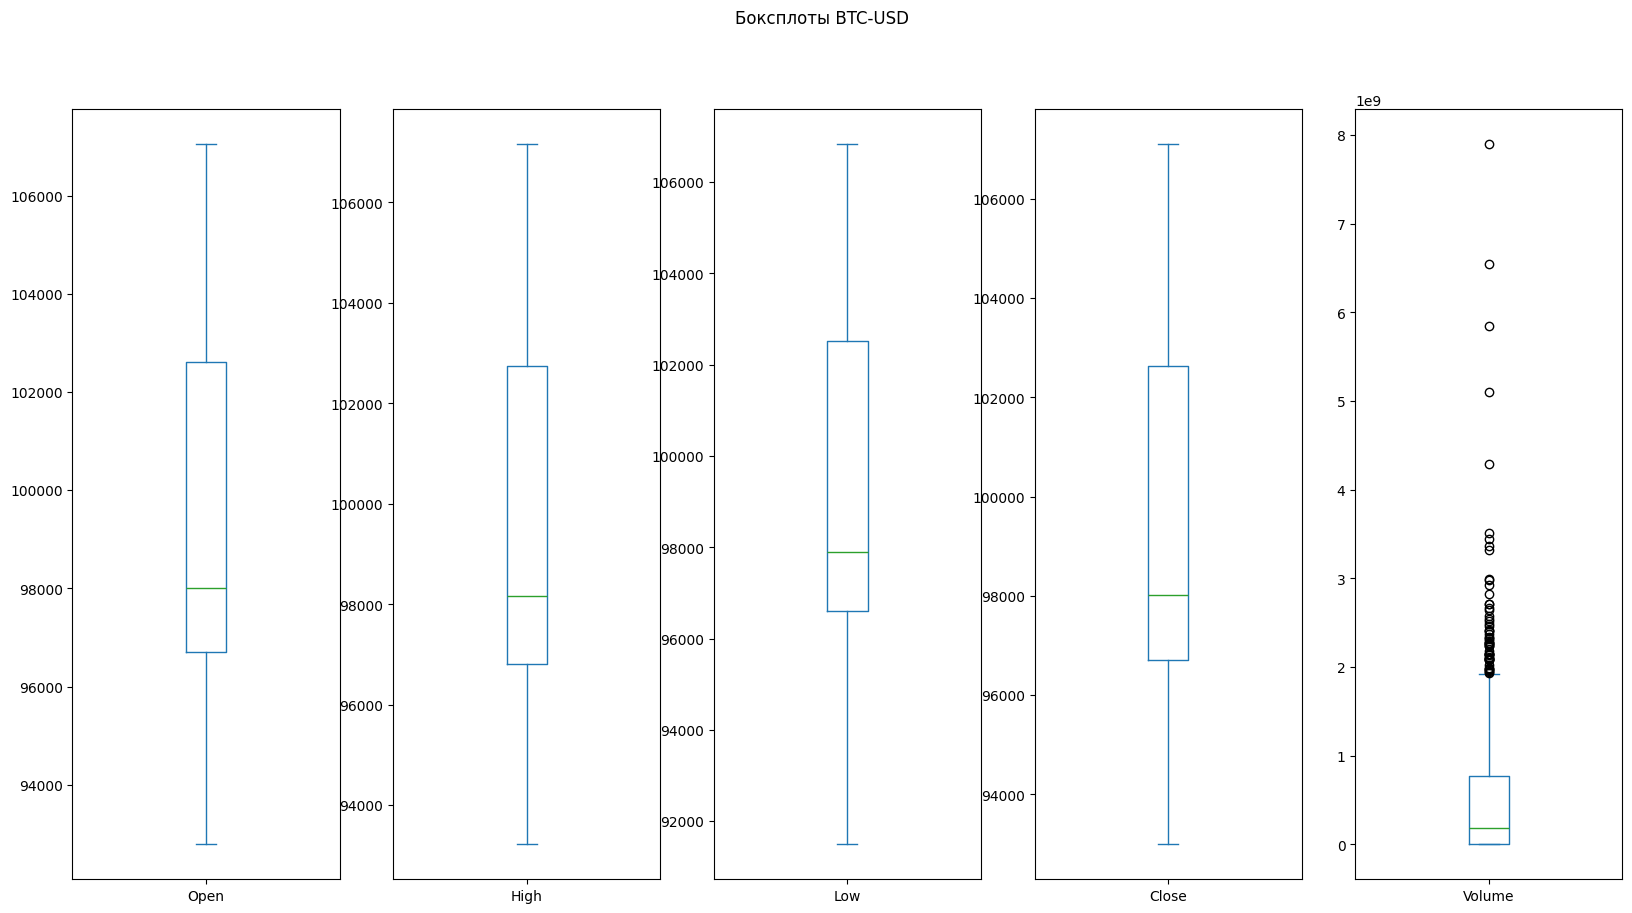

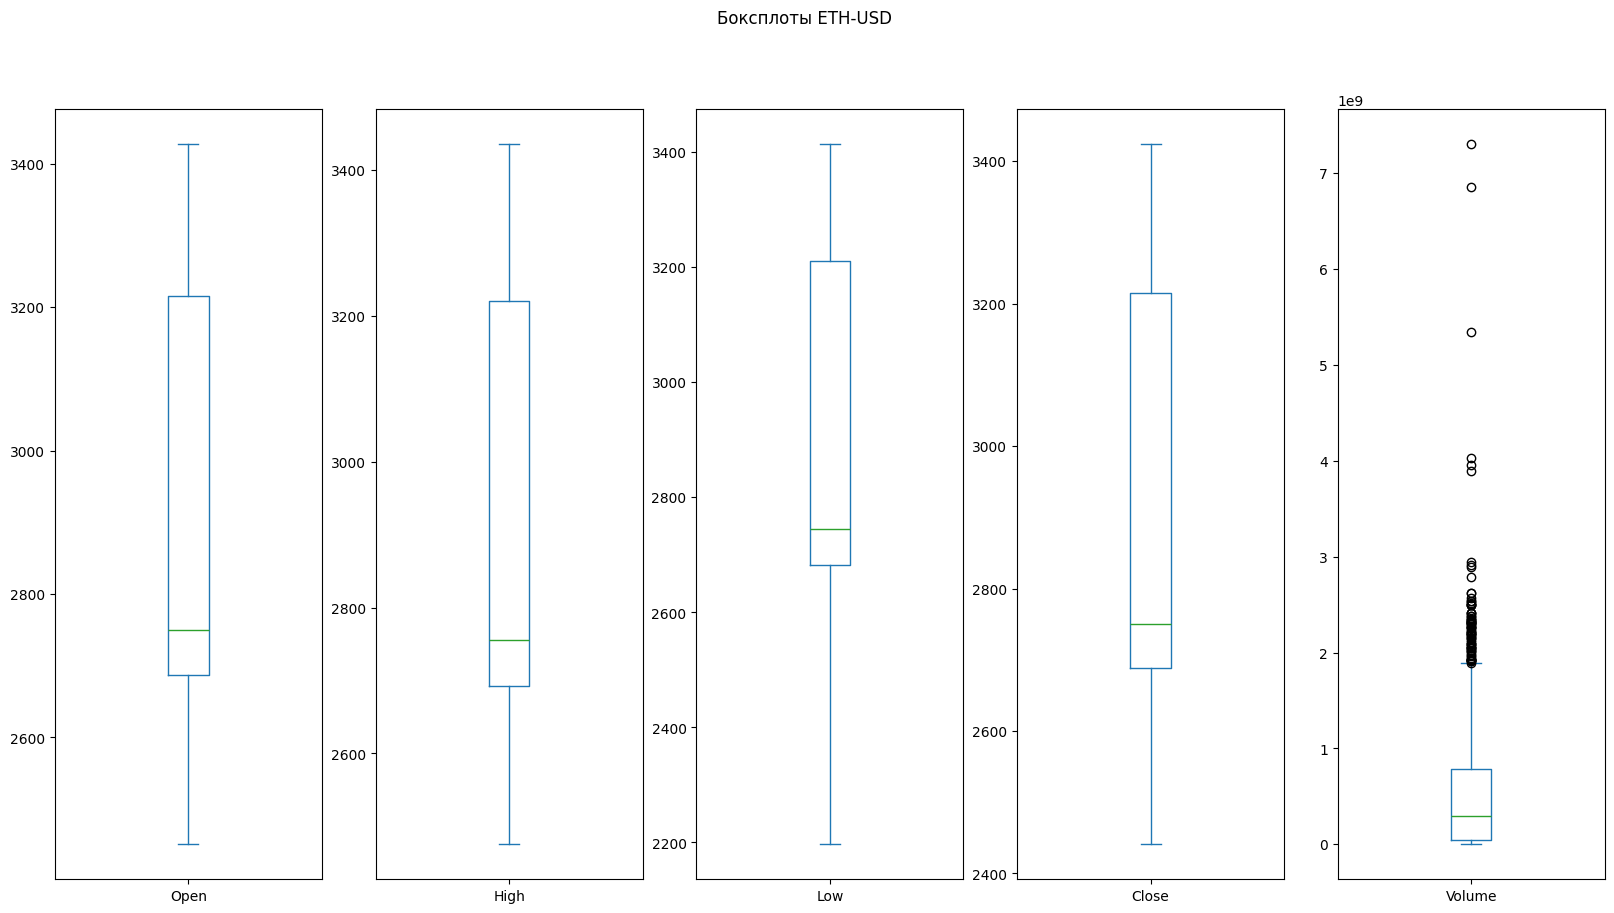

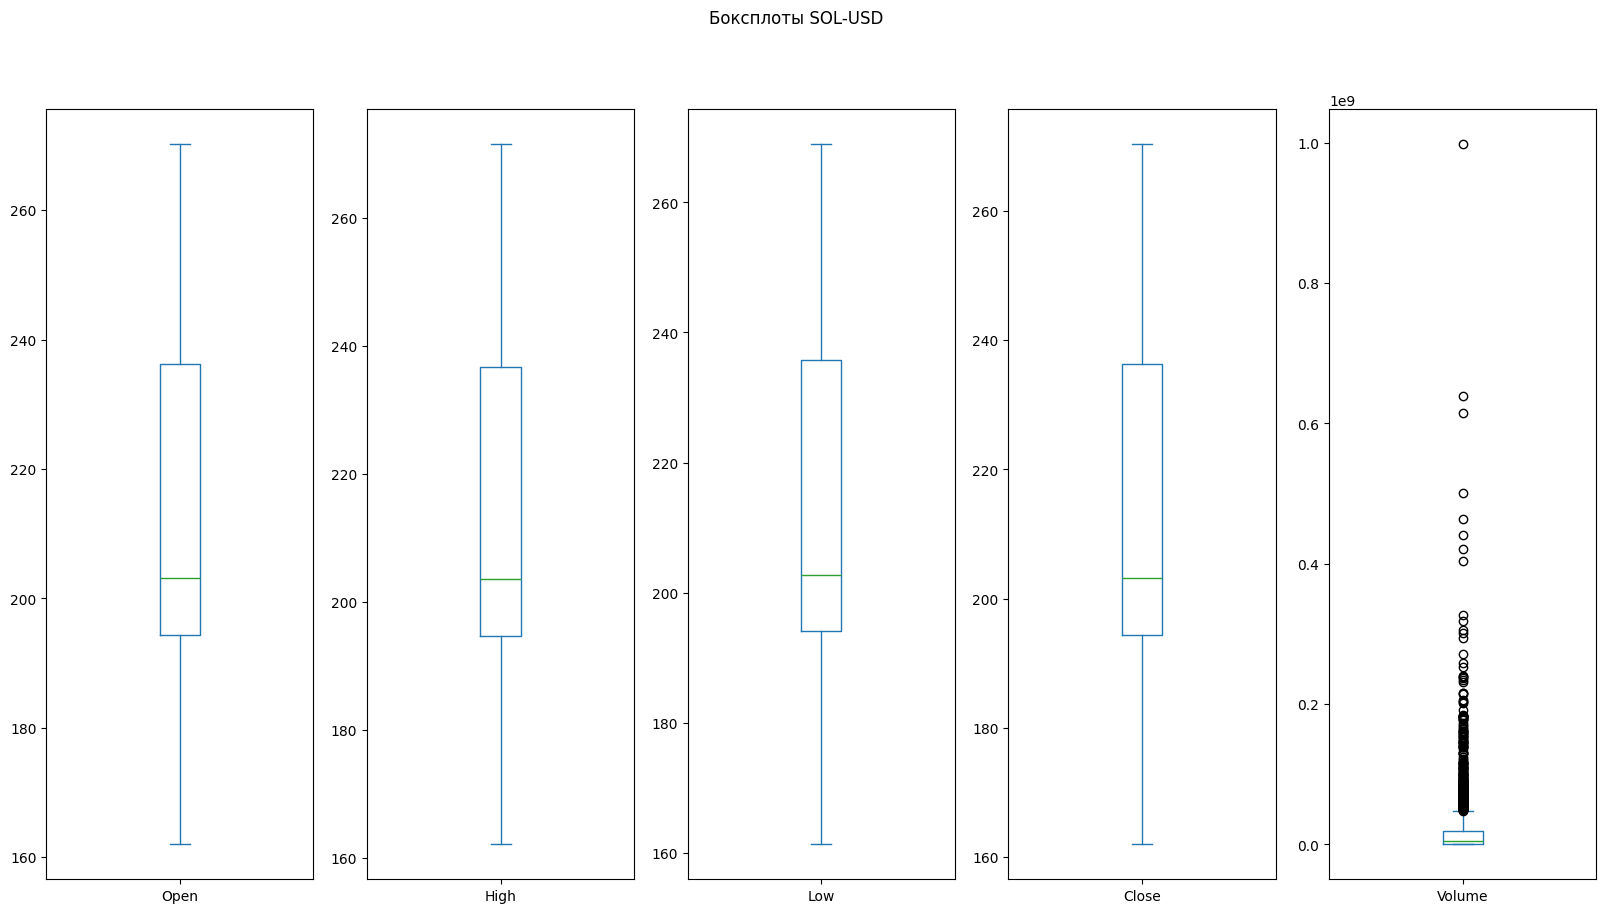

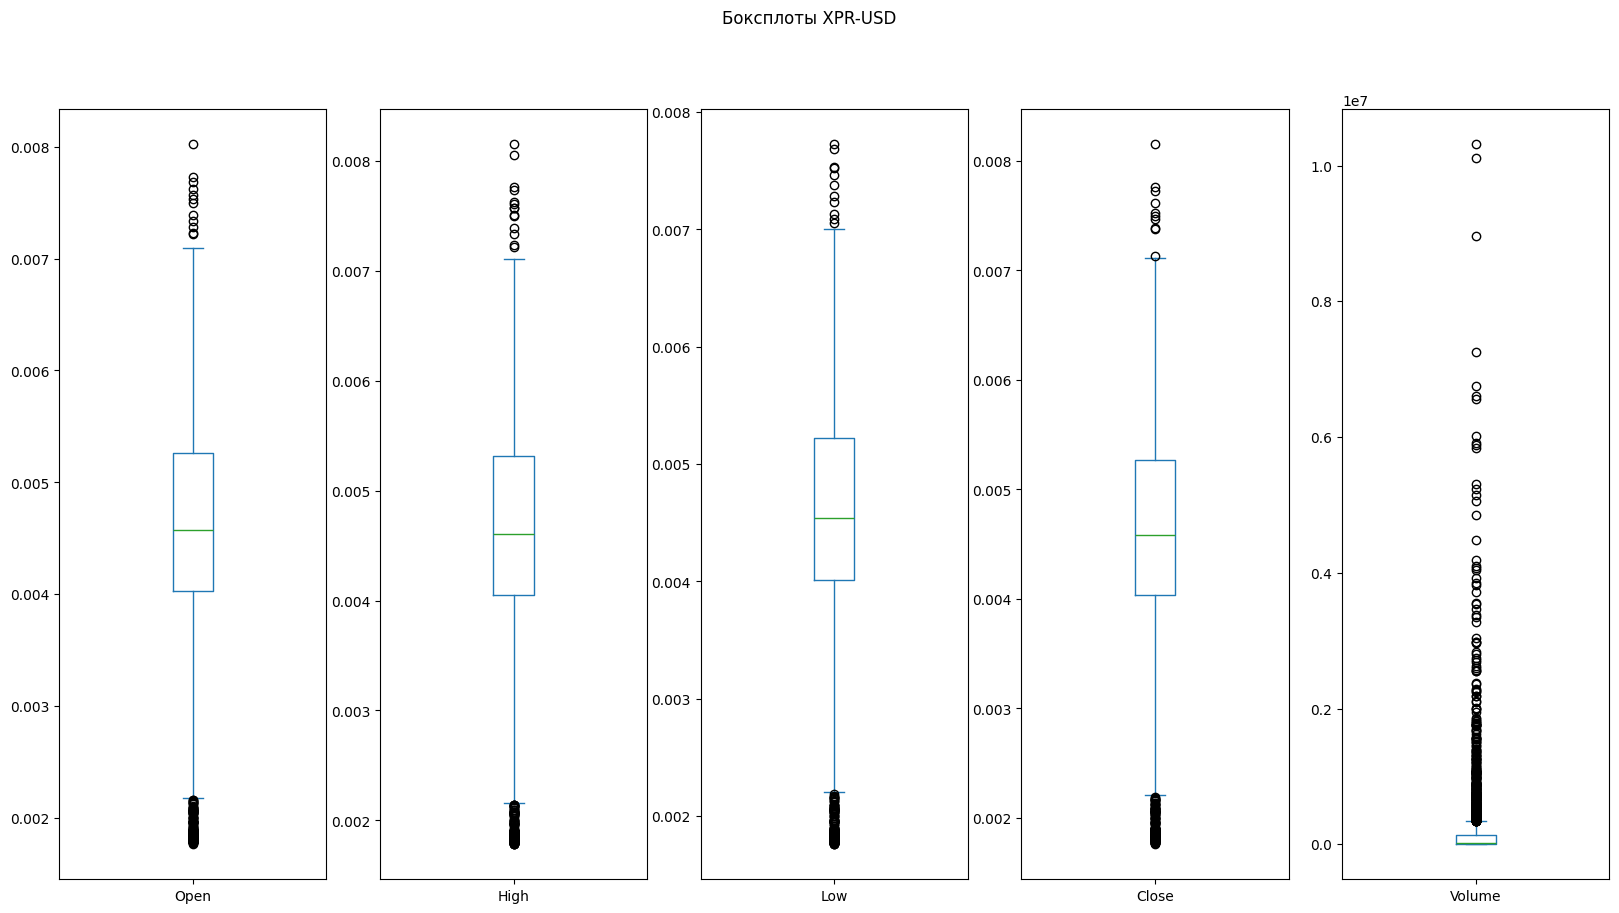

In [17]:
for ticker in tickers_snp_top5 + tickers_ccur:
    df_joined[ticker].plot(kind="box", figsize=(20, 10), subplots=True, title=f"Боксплоты {ticker}")

Боксплоты, построенные по правилу 1.5 * IQR, подсказывают, что в колонках с ценами присутствуют некоторые выбросы, а volume по его мнению - вообще месиво. Но, по моему мнению, речь о выбросах в финансовых данных можно вести только если:
1) инструмент - сильный неликвид, 1-2 странные сделки по нему могут значительно повлиять на данные; и/или
2) источник данных недостоверный, и данные могут быть неправильными 

Ни то, ни другое нас здесь не касается, поэтому я считаю, что в данных выбросов нет и нужно использовать при обучении модели всё, что имеем.

---

# ДЗ2

## 0. Импорты

In [18]:
from sklearn.model_selection import train_test_split
import talib
import plotly
from backtesting import Strategy, Backtest
import itertools
import warnings

В своей работе буду использовать только данные о BTC:

In [19]:
df = df_joined["BTC-USD"]

In [20]:
df

Price                               Open           High            Low  \
Datetime                                                                 
2025-01-21 08:30:00+00:00  102176.851562  102176.851562  101981.875000   
2025-01-21 08:45:00+00:00  102058.757812  102298.054688  101967.390625   
2025-01-21 09:00:00+00:00  102350.304688  102678.945312  102290.921875   
2025-01-21 09:15:00+00:00  102447.101562  102447.101562  102039.148438   
2025-01-21 09:30:00+00:00  102195.523438  102417.390625  102195.523438   
...                                  ...            ...            ...   
2025-02-21 07:30:00+00:00   98452.000000   98455.304688   98307.640625   
2025-02-21 07:45:00+00:00   98308.656250   98319.210938   98206.945312   
2025-02-21 08:00:00+00:00   98219.500000   98260.195312   98213.359375   
2025-02-21 08:15:00+00:00   98217.710938   98260.710938   98196.039062   
2025-02-21 08:30:00+00:00   98224.695312   98272.820312   98173.750000   

Price                              Close      Volume  
Datetime                                              
2025-01-21 08:30:00+00:00  102049.875000           0  
2025-01-21 08:45:00+00:00  102272.609375    30359552  
2025-01-21 09:00:00+00:00  102528.656250           0  
2025-01-21 09:15:00+00:00  102091.554688           0  
2025-01-21 09:30:00+00:00  102370.242188           0  
...                                  ...         ...  
2025-02-21 07:30:00+00:00   98312.500000   250210304  
2025-02-21 07:45:00+00:00   98206.945312  1753186304  
2025-02-21 08:00:00+00:00   98230.281250   216997888  
2025-02-21 08:15:00+00:00   98239.070312   946102272  
2025-02-21 08:30:00+00:00   98272.820312   203313152  

[2977 rows x 5 columns]

## 1. Создание стратегии стохастического осцилятора

In [21]:
class StochOscilatorStrategy(Strategy):

    def init(self):
        self.signal = self.I(lambda: self.data.Signal)
        self.previous_signal = 0
        self.size = 0.1

    def next(self):
        current_signal = self.signal[-1]

        if current_signal != self.previous_signal:
            if current_signal == 1:
                if self.position.is_short:
                    self.position.close()
                    
                if not self.position.is_long:
                    self.buy(size=self.size)
                    
            elif current_signal == -1:
                if self.position.is_long:
                    self.position.close()
                   
                if not self.position.is_short:
                    self.sell(size=self.size)
                    
            elif current_signal == 0:
                if self.position:
                    self.position.close()

        self.previous_signal = current_signal    

## 2. Подбор гиперпараметров

In [24]:
def apply_strategy(data, params):
    df = data.copy()

    fastk_period = params["fastk_period"]
    slowk_period = params["slowk_period"] 
    slowd_period = params["slowd_period"]

    df["Slowk"], df["Slowd"] = talib.STOCH(df["High"], df["Low"], df["Close"],
                                                        fastk_period=fastk_period, slowk_period=slowk_period, 
                                                        slowd_period=slowd_period)
    df["Signal"] = 0

    df.loc[df['Slowk'] > df['Slowd'], 'Signal'] = 1
    df.loc[df['Slowk'] < df['Slowd'], 'Signal'] = -1

    return df[["Open", "High", "Low", "Close", "Volume", "Signal"]]

def backtest_strategy(df, strategy_class, params, plot=False):
    df = apply_strategy(df, params)
    
    bt_df = df.copy()

    bt = Backtest(bt_df, strategy_class, cash=500000, commission=.002, exclusive_orders=True, margin=0.1)

    stats = bt.run()
    if plot:
        bt.plot(
        plot_equity=True,
        plot_drawdown=True,
        relative_equity=False,
        )
    return stats

def get_best_strategy(buffer, strategy_class):

    fastk_period = [10, 20, 30, 40]
    slowk_period = [5, 10, 15, 20]
    slowd_period = [3, 6, 9, 12]

    best_params = None
    best_performance = -float('inf') 

    for fastk_period_curr, slowk_period_curr, slowd_period_curr in itertools.product(fastk_period, slowk_period, slowd_period):
        
        params = {
            "fastk_period": fastk_period_curr, 
            "slowk_period": slowk_period_curr, 
            "slowd_period": slowd_period_curr
        }
        
        stats = backtest_strategy(buffer.copy(), strategy_class, params)

        performance = stats['Return [%]']
        
        if performance > best_performance:
            best_performance = performance
            best_params = params

    print(f"Best Performance: {best_performance}")
    print(f"Best Parameters: {best_params}")
    return best_params

In [25]:
train_size = 60
test_size = 20

signals_df = pd.DataFrame()

num_iterations = (len(df) - train_size) // test_size

for i in range(num_iterations + 1):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        start_train = i * test_size
        end_train = start_train + train_size
        start_test = end_train
        end_test = start_test + test_size
    
        if end_test > len(df):
            end_test = len(df)
    
        train_data = df.iloc[start_train:end_train].copy()
        test_data = df.iloc[start_test:end_test].copy()
    
        best_params = get_best_strategy(train_data, StochOscilatorStrategy)
    
        combined_data = pd.concat([train_data, test_data]).reset_index(drop=True)
        combined_with_signal = apply_strategy(combined_data.copy(), best_params)
        test_with_signal = combined_with_signal.iloc[-test_size:].copy()
    
        signals_df = pd.concat([signals_df, test_with_signal], ignore_index=True)

Best Performance: 0.7177478125000023
Best Parameters: {'fastk_period': 20, 'slowk_period': 10, 'slowd_period': 3}
Best Performance: 0.1679477749999962
Best Parameters: {'fastk_period': 20, 'slowk_period': 15, 'slowd_period': 9}
Best Performance: 0.0
Best Parameters: {'fastk_period': 40, 'slowk_period': 15, 'slowd_period': 9}
Best Performance: 0.44079340000000083
Best Parameters: {'fastk_period': 40, 'slowk_period': 5, 'slowd_period': 3}
Best Performance: 0.010796849999995901
Best Parameters: {'fastk_period': 30, 'slowk_period': 20, 'slowd_period': 12}
Best Performance: 0.18585942499999655
Best Parameters: {'fastk_period': 30, 'slowk_period': 10, 'slowd_period': 9}
Best Performance: 0.9516334875000058
Best Parameters: {'fastk_period': 10, 'slowk_period': 20, 'slowd_period': 3}
Best Performance: 0.29509174999999815
Best Parameters: {'fastk_period': 40, 'slowk_period': 5, 'slowd_period': 12}
Best Performance: 1.5686980500000063
Best Parameters: {'fastk_period': 20, 'slowk_period': 10, 'sl

In [27]:
bt_df = signals_df.copy()

bt = Backtest(bt_df, StochOscilatorStrategy, cash=500000, commission=0.002, exclusive_orders=True, margin=0.1)


stats = bt.run()
print(stats[:27])
bt.plot(
plot_equity=True,
plot_drawdown=True,
relative_equity=False,
)

C:\Users\mtkar\AppData\Local\Temp\ipykernel_2028\3491581089.py:3: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Start                               0.0
End                              2919.0
Duration                         2919.0
Exposure Time [%]             99.828767
Equity Final [$]          281651.539734
Equity Peak [$]           501645.207625
Return [%]                   -43.669692
Buy & Hold Return [%]         -7.282159
Return (Ann.) [%]                   0.0
Volatility (Ann.) [%]               NaN
Sharpe Ratio                        NaN
Sortino Ratio                       NaN
Calmar Ratio                        0.0
Max. Drawdown [%]            -43.861511
Avg. Drawdown [%]            -14.635243
Max. Drawdown Duration           2911.0
Avg. Drawdown Duration            972.0
# Trades                          349.0
Win Rate [%]                  24.068768
Best Trade [%]                 3.070257
Worst Trade [%]               -2.962125
Avg. Trade [%]                -0.188365
Max. Trade Duration                42.0
Avg. Trade Duration             8.30086
Profit Factor                  0.474597


GridPlot(id='p1805', ...)